<a href="https://colab.research.google.com/github/alicewoo0925/Skin-Leison-Classification/blob/main/skin%20leison%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [ ]:
# set up the environment
# import modules
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from skimage import io # to read image files
from skimage.color import rgb2gray # to convert RGB image to grayscale
from scipy import stats # for first order statistic
from skimage.feature import greycomatrix, greycoprops # for text features
from skimage.segmentation import * # segmentation
from skimage.morphology import binary_dilation # morphological operators
from skimage.filters import threshold_otsu # for Otsu threshold

In [ ]:
# using Google Colaboratory
from google.colab import files
from google.colab import drive

# link to Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Read CSV data

In [ ]:
# read CSV file
train_truth = pd.read_csv('/content/gdrive/MyDrive/bmet5933/assignment1/training_data_ground_truth.csv')

# convert column to list
tr_fnames_disease = train_truth['case_number'].tolist()
tr_disease_status = train_truth['disease_status'].tolist()

In [ ]:
# read file names
tr_benign_fname = []
tr_malig_fname = []

j = 0

for i in tr_disease_status:
  if i == 'benign':
    tr_benign_fname.append(tr_fnames_disease[j])
  elif i == 'malignant':
    tr_malig_fname.append(tr_fnames_disease[j])
  j = j+1

# Load image data

In [ ]:
path_train = '/content/gdrive/MyDrive/bmet5933/assignment1/assignment1_train_test_data/assign_train'

In [ ]:
# read benign images and mask
tr_benign_images = []
tr_benign_masks = []

for fname in tr_benign_fname:
  img = io.imread(path_train+'/'+ fname +'.jpg')
  tr_benign_images.append(img)

for fname in tr_benign_fname:
  img = io.imread(path_train+'/'+ fname +'_Segmentation.png')
  tr_benign_masks.append(img)

In [ ]:
# read malig images and masks
tr_malig_images = []
tr_malig_masks = []

for fname in tr_malig_fname:
  img = io.imread(path_train+'/'+ fname +'.jpg')
  tr_malig_images.append(img)

for fname in tr_malig_fname:
  img = io.imread(path_train+'/'+ fname +'_Segmentation.png')
  tr_malig_masks.append(img)

In [ ]:
# read demo sample data
path = '/content/gdrive/MyDrive/bmet5933/assignment1/assignment1_demo_sample_data/assign_demo_sample/'

demo_benign_image = io.imread(path+'ISIC_0000126-b.jpg')
demo_benign_mask = io.imread(path+'ISIC_0000126_Segmentation-b.png')

demo_malig_image = io.imread(path+'ISIC_0010863-m.jpg')
demo_malig_mask = io.imread(path+'ISIC_0010863_Segmentation-m.png')

In [ ]:
np.shape(demo_benign_image)

(1536, 2048, 3)

# Histogram

In [ ]:
# a function to obtain histrogram
def getHistogram(images,masks):
  # initialise the histogram list of each channels
  hist_b = []
  hist_g = []
  hist_r = []
  hist_k = []

  # if full image
  if masks == None:
    # mask is None
    mask = masks

    for img in images:
      # convert the image to grayscale
      img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

      # produce histogram and store in a list
      hist_b.append(cv2.calcHist([img],[0],mask,[256],[0,256]))
      hist_g.append(cv2.calcHist([img],[1],mask,[256],[0,256]))
      hist_r.append(cv2.calcHist([img],[2],mask,[256],[0,256]))
      hist_k.append(cv2.calcHist([img_gray],[0],mask,[256],[0,256]))

  # else masked image
  else:
    for img, mask in zip(images, masks):
      # convert the image to grayscale
      img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

      # produce histogram and store in a list
      hist_b.append(cv2.calcHist([img],[0],mask,[256],[0,256]))
      hist_g.append(cv2.calcHist([img],[1],mask,[256],[0,256]))
      hist_r.append(cv2.calcHist([img],[2],mask,[256],[0,256]))
      hist_k.append(cv2.calcHist([img_gray],[0],mask,[256],[0,256]))

  # average the histograms
  hist_b = np.mean(hist_b, axis = 0)
  hist_g = np.mean(hist_g, axis = 0)
  hist_r = np.mean(hist_r, axis = 0)
  hist_k = np.mean(hist_k, axis = 0)

  plt.plot(hist_b, color = 'b')
  plt.plot(hist_g, color = 'g')
  plt.plot(hist_r, color = 'r')
  plt.plot(hist_k, color = 'k')
  plt.xlim([0,256])

## Averaged histogram of raw images

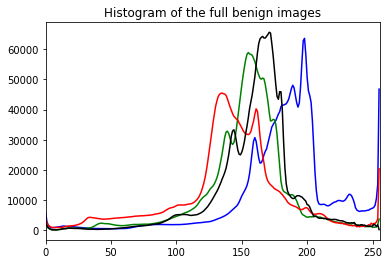

In [ ]:
# produce histogram of the full benign images
plt.title('Histogram of the full benign images')
getHistogram(tr_benign_images, None)
plt.show()

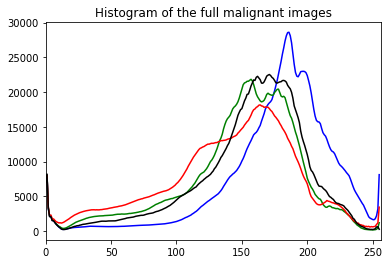

In [ ]:
# produce histogram of the full malignant images
plt.title('Histogram of the full malignant images')
getHistogram(tr_malig_images, None)
plt.show()

## Averaged histogram of masked images

In [ ]:
# apply mask to benign images
tr_masked_benign = []
for img, mask in zip(tr_benign_images, tr_benign_masks):
  tr_masked_benign.append(cv2.bitwise_and(img,img,mask = mask))

In [ ]:
# apply mask to malignant images
tr_masked_malig = []
for img, mask in zip(tr_malig_images, tr_malig_masks):
  tr_masked_malig.append(cv2.bitwise_and(img,img,mask = mask))

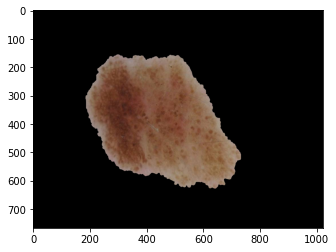

In [ ]:
plt.imshow(tr_masked_benign[0])

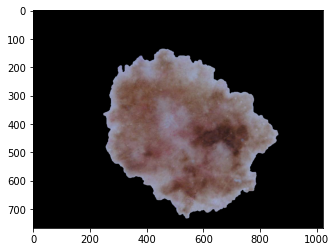

In [ ]:
plt.imshow(tr_masked_malig[0])

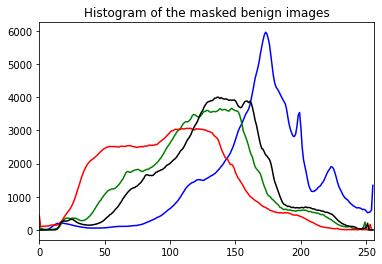

In [ ]:
# produce histogram of the masked benign images
plt.title('Histogram of the masked benign images')
getHistogram(tr_masked_benign,tr_benign_masks)
plt.show()

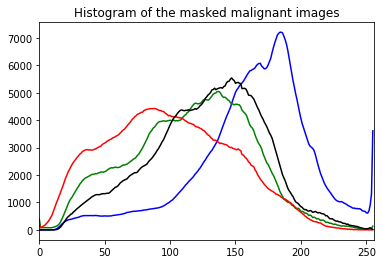

In [ ]:
# produce histogram of the masked malignant images
plt.title('Histogram of the masked malignant images')
getHistogram(tr_masked_malig, tr_malig_masks)
plt.show()

## Demo: histogram of images

In [ ]:
# a function to obtain histrogram
def getHistogram(img,mask):

  # if full image
  if mask == 'None':

    # convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # produce histogram and store in a list
    hist_b = (cv2.calcHist([img],[0],mask,[256],[0,256]))
    hist_g = (cv2.calcHist([img],[1],mask,[256],[0,256]))
    hist_r = (cv2.calcHist([img],[2],mask,[256],[0,256]))
    hist_k = (cv2.calcHist([img_gray],[0],mask,[256],[0,256]))

  # else masked image
  else:

    # convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # produce histogram and store in a list
    hist_b = (cv2.calcHist([img],[0],mask,[256],[0,256]))
    hist_g = (cv2.calcHist([img],[1],mask,[256],[0,256]))
    hist_r = (cv2.calcHist([img],[2],mask,[256],[0,256]))
    hist_k = (cv2.calcHist([img_gray],[0],mask,[256],[0,256]))

  plt.plot(hist_b, color = 'b')
  plt.plot(hist_g, color = 'g')
  plt.plot(hist_r, color = 'r')
  plt.plot(hist_k, color = 'k')
  plt.xlim([0,256])

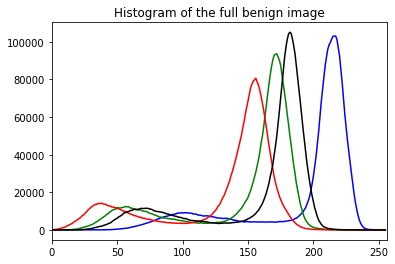

In [ ]:
# produce histogram of the full benign image
plt.title('Histogram of the full benign image')
getHistogram(demo_benign_image, None)
plt.show()

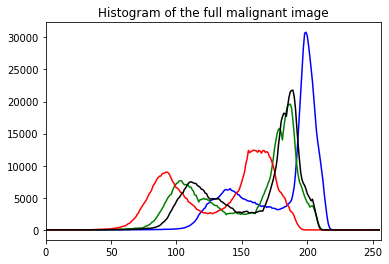

In [ ]:
# produce histogram of the full malignant image
plt.title('Histogram of the full malignant image')
getHistogram(demo_malig_image, None)
plt.show()

In [ ]:
# apply mask to images
demo_masked_benign =(cv2.bitwise_and(demo_benign_image,demo_benign_image,mask = demo_benign_mask))
demo_masked_malig =(cv2.bitwise_and(demo_malig_image,demo_malig_image,mask = demo_malig_mask))

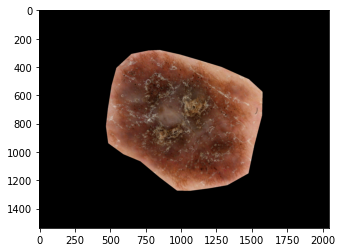

In [ ]:
plt.imshow(demo_masked_benign)

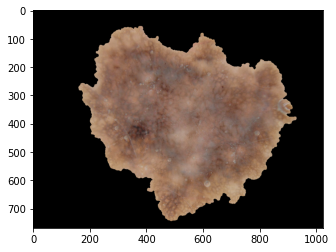

In [ ]:
plt.imshow(demo_masked_malig)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


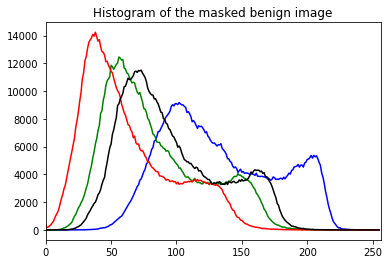

In [ ]:
# produce histogram of the masked benign image
plt.title('Histogram of the masked benign image')
getHistogram(demo_masked_benign,demo_benign_mask)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


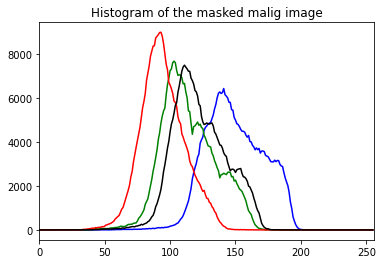

In [ ]:
# produce histogram of the masked malig image
plt.title('Histogram of the masked malig image')
getHistogram(demo_masked_malig,demo_malig_mask)
plt.show()

# Feature

## First order statistics

In [ ]:
# a function to obtain first order statistics
def getFirstOrderStats(images):
  # define dictionary
  stats_dic = ['entropy','mean','variance','skewness','kurtosis']

  # initialise the first order statistics features list
  first_order_list = []

  for img in images:
    # conver the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # obtain the values
    entropy = stats.entropy(img,axis=None)
    img_stats = stats.describe(img,axis=None)
    first_order_array = np.array([entropy,
                                  img_stats.mean,
                                  img_stats.variance,
                                  img_stats.skewness,
                                  img_stats.kurtosis])
    # store the values in the list
    first_order_list.append(first_order_array)

  # average the values
  first_order_list = np.mean(first_order_list, axis = 0)

  # a final list for the first order statistics
  first_order_stats = {stats_dic[i]: first_order_list[i] for i in range(len(stats_dic))}
  return first_order_stats

In [ ]:
# first order statistics for full benign images
getFirstOrderStats(tr_benign_images)

{'entropy': 15.258922469403442,
 'kurtosis': 2.6760621045700654,
 'mean': 164.37954943862323,
 'skewness': -1.266850289573079,
 'variance': 1699.5700165056933}

In [ ]:
# first order statistics for full malignant images
getFirstOrderStats(tr_malig_images)

{'entropy': 15.045663082720505,
 'kurtosis': 1.0448525109413012,
 'mean': 154.78437807911385,
 'skewness': -0.9689596574991136,
 'variance': 2057.463431944595}

In [ ]:
# first order statistics for masked benign images
getFirstOrderStats(tr_masked_benign)

{'entropy': 13.433410128360984,
 'kurtosis': 8.595610234590012,
 'mean': 32.80036909965899,
 'skewness': 2.4742062102530626,
 'variance': 2886.3055127658445}

In [ ]:
# first order statistics for masked malignant images
getFirstOrderStats(tr_masked_malig)

{'entropy': 13.778827238523121,
 'kurtosis': 2.7604719348300573,
 'mean': 46.46962075351444,
 'skewness': 1.4625448286243266,
 'variance': 3739.055897681401}

## Demo: First Order Statistics

In [ ]:
# a function to obtain first order statistics
def getFirstOrderStats(img):
  # define dictionary
  stats_dic = ['entropy','mean','variance','skewness','kurtosis']

  # conver the image to grayscale
  img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # obtain the values
  entropy = stats.entropy(img,axis=None)
  img_stats = stats.describe(img,axis=None)
  first_order_array = np.array([entropy,
                                img_stats.mean,
                                img_stats.variance,
                                img_stats.skewness,
                                img_stats.kurtosis])

  # a final list for the first order statistics
  first_order_stats = {stats_dic[i]: first_order_array[i] for i in range(len(stats_dic))}
  return first_order_stats

In [ ]:
# first order statistics for full benign image
getFirstOrderStats(demo_benign_image)

{'entropy': 15.994701707176288,
 'kurtosis': 0.08082079030400724,
 'mean': 156.31142467922635,
 'skewness': -0.8461148241443432,
 'variance': 2677.8084756423264}

In [ ]:
# first order statistics for full malig image
getFirstOrderStats(demo_malig_image)

{'entropy': 14.639769785765662,
 'kurtosis': -0.8749502998889485,
 'mean': 155.5724288092719,
 'skewness': -0.5203283009143034,
 'variance': 1538.663502144768}

In [ ]:
# first order statistics for masked benign image
getFirstOrderStats(demo_masked_benign)

{'entropy': 14.606446253283389,
 'kurtosis': 2.983431312496042,
 'mean': 24.833478609720867,
 'skewness': 1.9622491304338103,
 'variance': 2313.0362185199833}

In [ ]:
# first order statistics for masked malig image
getFirstOrderStats(demo_masked_malig)

{'entropy': 13.77562826577413,
 'kurtosis': -1.2371504422554243,
 'mean': 50.217603047688804,
 'skewness': 0.6218437583429914,
 'variance': 3856.8639194214143}

## Texture

In [ ]:
# glcm
def getGLCM(images):
  # initialise a list for entire images
  glcm_list = []

  for image in images:

    # convert an image to grayscale
    img_gray = rgb2gray(image)

    # create a binned version
    FACTOR = np.max(img_gray) / (256-1)
    binned = img_gray // FACTOR

    # ensure the image is of an integer type
    integer = binned.astype(int)

    # compute the matrix
    glcm = greycomatrix(integer,
                        distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256)

    # define the features
    features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

    # initialise features for individual images
    features_img = []

    # using for loop to compute the features
    for feature in features:
      output = (greycoprops(glcm, feature)[0,0])
      features_img.append(output)

    # append the list for entire images
    glcm_list.append(features_img)

  # mean obtained glcm
  glcm_mean = np.mean(glcm_list,axis=0)

  # create a dictionary
  glcm_outcome = {features[i]: glcm_mean[i] for i in range(len(features))}

  return glcm_outcome

In [ ]:
# mean GLCM for full benign image
getGLCM(tr_benign_images)

{'ASM': 0.005426891130984967,
 'contrast': 22.583171276979154,
 'correlation': 0.9856187689097107,
 'dissimilarity': 1.8501656455832776,
 'energy': 0.06756714217728776,
 'homogeneity': 0.5085115616145692}

In [ ]:
# mean GLCM for full malig image
getGLCM(tr_malig_images)

{'ASM': 0.005671239937992539,
 'contrast': 25.495193205235477,
 'correlation': 0.9890461484569298,
 'dissimilarity': 2.086289967508115,
 'energy': 0.05688712355988496,
 'homogeneity': 0.4629150737244909}

In [ ]:
# mean GLCM for masked benign image
getGLCM(tr_masked_benign)

{'ASM': 0.619827834375771,
 'contrast': 54.08306314780978,
 'correlation': 0.9923320052465984,
 'dissimilarity': 0.8527442879768973,
 'energy': 0.7594275237567034,
 'homogeneity': 0.8533539557582062}

In [ ]:
# mean GLCM for masked malig image
getGLCM(tr_masked_malig)

{'ASM': 0.468462154748736,
 'contrast': 65.22954417379208,
 'correlation': 0.9919504915947147,
 'dissimilarity': 1.2278261524123804,
 'energy': 0.6495679847437673,
 'homogeneity': 0.7813834658761027}

## Demo: Texture

In [ ]:
# glcm
def getGLCM(img):

  # convert an image to grayscale
  img_gray = rgb2gray(img)

  # create a binned version
  FACTOR = np.max(img_gray) / (256-1)
  binned = img_gray // FACTOR

  # ensure the image is of an integer type
  integer = binned.astype(int)

  # compute the matrix
  glcm = greycomatrix(integer,
                      distances=[1],
                      angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                      levels=256)

  # define the features
  features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

  # initialise features for individual images
  features_img = {}

  # using for loop to compute the features
  for feature in features:
    output = (greycoprops(glcm, feature)[0,0])
    features_img[feature] = output

  return features_img

In [ ]:
# GLCM for full benign image
getGLCM(demo_benign_image)

{'ASM': 0.001488314621942859,
 'contrast': 17.706925976530684,
 'correlation': 0.9954413621747324,
 'dissimilarity': 2.8965060021779854,
 'energy': 0.03857868092538752,
 'homogeneity': 0.3186137032307563}

In [ ]:
# GLCM for full malignant image
getGLCM(demo_malig_image)

{'ASM': 0.001651955317100956,
 'contrast': 9.46956332478006,
 'correlation': 0.9970331082416811,
 'dissimilarity': 2.02446211102965,
 'energy': 0.0406442531866555,
 'homogeneity': 0.42257572302624635}

In [ ]:
# GLCM for masked benign image
getGLCM(demo_masked_malig)

{'ASM': 0.3343883536477772,
 'contrast': 106.17557123655911,
 'correlation': 0.9905507897495405,
 'dissimilarity': 1.7476911249592706,
 'energy': 0.5782632217665041,
 'homogeneity': 0.7097553841456574}

In [ ]:
# GLCM for masked malignant image
getGLCM(demo_masked_malig)

{'ASM': 0.3343883536477772,
 'contrast': 106.17557123655911,
 'correlation': 0.9905507897495405,
 'dissimilarity': 1.7476911249592706,
 'energy': 0.5782632217665041,
 'homogeneity': 0.7097553841456574}

# Segmentation

## Region grow

In [ ]:
# a function to display the outcome of region grow segmentation
def regionGrow(img):
  img_gray = rgb2gray(img)

  r,c = np.shape(img_gray)
  ROW = round(r/2)
  COL = round(c/2)
  TOLERANCE_VALUE = 0.25

  #lesion_rg = flood(img_gray, seed_point =(500,500), tolerance=TOLERANCE_VALUE)
  lesion_rg = flood(img_gray, seed_point=(ROW,COL), tolerance=TOLERANCE_VALUE)

  # fill in holes with dilation
  lesion_rg = binary_dilation(lesion_rg)

  # display the output
  plt.imshow(lesion_rg, cmap='gray')
  plt.show()

ISIC_0000009


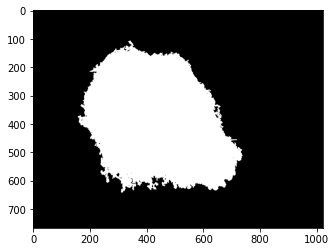

ISIC_0000263


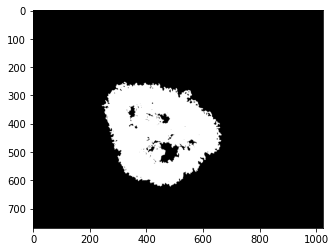

ISIC_0002093


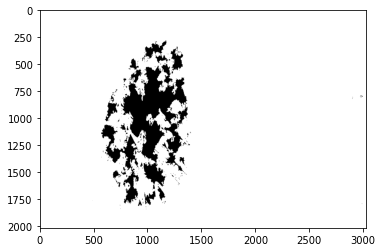

ISIC_0009979


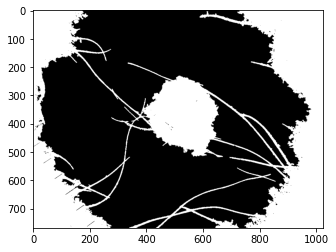

ISIC_0010439


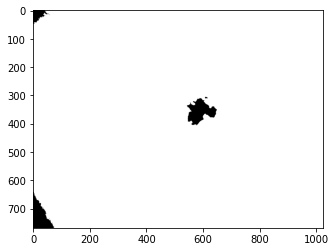

In [ ]:
# region grow segmentation
for i in range(0,len(tr_benign_fname),15):
  print(tr_benign_fname[i])
  regionGrow(tr_benign_images[i])

## Level sets

In [ ]:
# a function for level set segmentation
def levelSets(img):
  img_gray = rgb2gray(img)
  initial_boxes = checkerboard_level_set(img_gray.shape,square_size=5)
  NUM_ITERATIONS = 100
  INITIAL_CONTOUR = initial_boxes
  SMOOTH_VALUE = 2

  level_set_contour = morphological_chan_vese(img_gray,
                                              iterations=NUM_ITERATIONS,
                                              init_level_set=INITIAL_CONTOUR,
                                              smoothing=SMOOTH_VALUE)

  r, c = np.shape(img_gray)

  ROW = 5
  COL = 5
  MASK_VALUE = 0
  TOLERANCE_VALUE = 0

  level_set_contour = flood_fill(level_set_contour, seed_point=(ROW,COL),new_value=MASK_VALUE, tolerance=TOLERANCE_VALUE) # left top
  level_set_contour = flood_fill(level_set_contour, seed_point=(ROW,c-COL),new_value=MASK_VALUE, tolerance=TOLERANCE_VALUE) # right top
  level_set_contour = flood_fill(level_set_contour, seed_point=(r-ROW,COL),new_value=MASK_VALUE, tolerance=TOLERANCE_VALUE) # left bottom
  level_set_contour = flood_fill(level_set_contour, seed_point=(r-ROW,c-COL),new_value=MASK_VALUE, tolerance=TOLERANCE_VALUE) # right bottom

  return level_set_contour

In [ ]:
# a function to display the outcome of level set segmentation
def levelSetsDisplay(img):
  img_gray = rgb2gray(img)
  initial_boxes = checkerboard_level_set(img_gray.shape,square_size=5)
  NUM_ITERATIONS = 45
  INITIAL_CONTOUR = initial_boxes
  SMOOTH_VALUE = 2

  level_set_contour = morphological_chan_vese(img_gray,
                                              iterations=NUM_ITERATIONS,
                                              init_level_set=INITIAL_CONTOUR,
                                              smoothing=SMOOTH_VALUE)

  r, c = np.shape(img_gray)

  ROW = 5
  COL = 5
  MASK_VALUE = 0
  TOLERANCE_VALUE = 0

  level_set_contour = flood_fill(level_set_contour, seed_point=(ROW,COL),new_value=MASK_VALUE, tolerance=TOLERANCE_VALUE) # left top
  level_set_contour = flood_fill(level_set_contour, seed_point=(ROW,c-COL),new_value=MASK_VALUE, tolerance=TOLERANCE_VALUE) # right top
  level_set_contour = flood_fill(level_set_contour, seed_point=(r-ROW,COL),new_value=MASK_VALUE, tolerance=TOLERANCE_VALUE) # left bottom
  level_set_contour = flood_fill(level_set_contour, seed_point=(r-ROW,c-COL),new_value=MASK_VALUE, tolerance=TOLERANCE_VALUE) # right bottom

  plt.imshow(level_set_contour, cmap = 'gray')
  plt.show()

ISIC_0000009


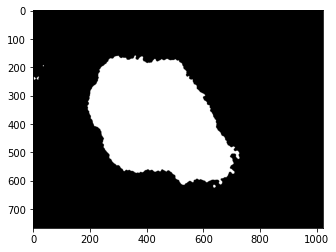

ISIC_0000263


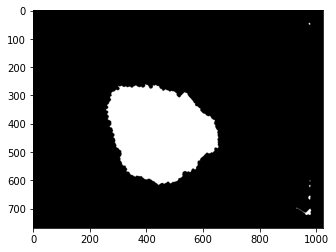

ISIC_0002093


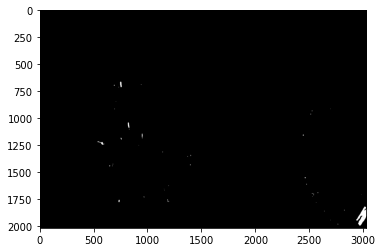

ISIC_0009979


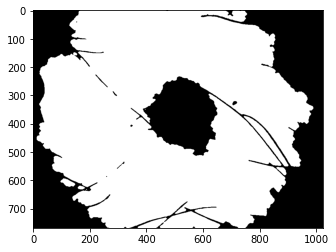

ISIC_0010439


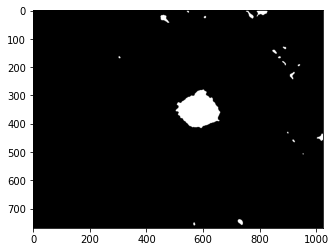

In [ ]:
# level sets segmentation
for i in range(0,len(tr_benign_fname),15):
  print(tr_benign_fname[i])
  levelSetsDisplay(tr_benign_images[i])

## Otsu thresholding

In [ ]:
# a function for otsu thresholding segmentation
def otsuThres(img):
  img_gray = rgb2gray(img)
  # get the threshold value
  thres = threshold_otsu(img_gray)

  # generate the thresholding mask
  LOWER = 0
  UPPER = thres
  otsu_thres = (img_gray > LOWER) & (img_gray < UPPER)

  # fill in holes with dilation
  otsu_thres = binary_dilation(otsu_thres)

  return otsu_thres

In [ ]:
# a function to display the outcome for otsu thresholding segmentation
def otsuThresDisplay(img):
  img_gray = rgb2gray(img)
  # get the threshold value
  thres = threshold_otsu(img_gray)

  # show the value
  print('threshold: ', thres)

  # generate the thresholding mask
  LOWER = 0
  UPPER = thres
  otsu_thres = (img_gray > LOWER) & (img_gray < UPPER)

  # fill in holes with dilation
  otsu_thres = binary_dilation(otsu_thres)

  plt.imshow(otsu_thres, cmap = 'gray')
  plt.show()

ISIC_0000009
threshold:  0.525390625


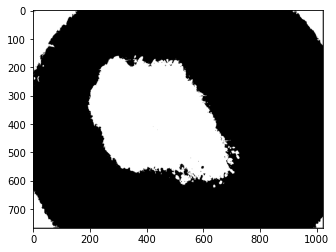

ISIC_0000263
threshold:  0.5934988105085786


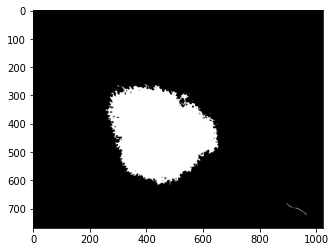

ISIC_0002093
threshold:  0.3945364583333333


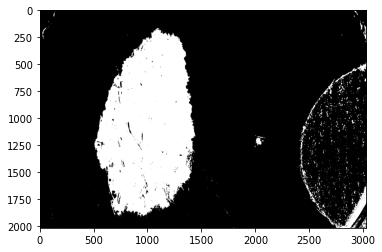

ISIC_0009979
threshold:  0.8155387837009804


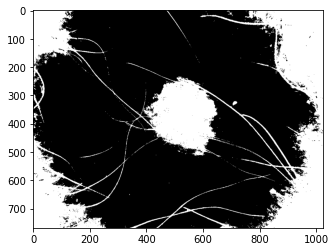

ISIC_0010439
threshold:  0.7529342938112746


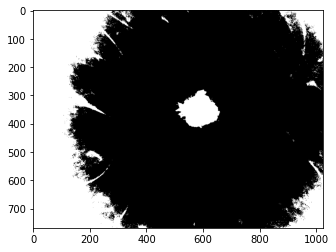

In [ ]:
# Otsu threshold segmentation
for i in range(0,len(tr_benign_fname),15):
  print(tr_benign_fname[i])
  otsuThresDisplay(tr_benign_images[i])

## Demo: Otsu threshold

threshold:  0.49223590150122554


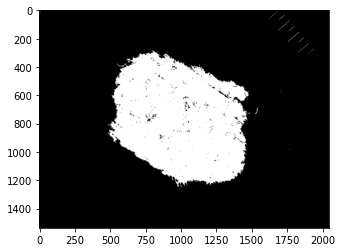

In [ ]:
# display the outcome
otsuThresDisplay(demo_benign_image)

threshold:  0.49223590150122554


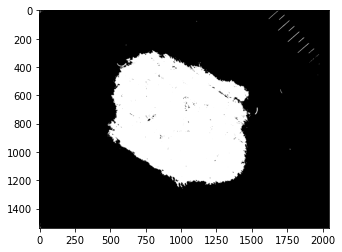

In [ ]:
# display the outcome
otsuThresDisplay(demo_benign_image)

threshold:  0.5860891819852941


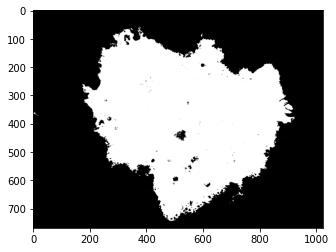

In [ ]:
# display the outcome
otsuThresDisplay(demo_malig_image)

threshold:  0.5860891819852941


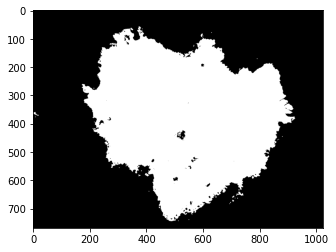

In [ ]:
# display the outcome
otsuThresDisplay(demo_malig_image)

## Segmentation evaluation

In [ ]:
# a function to obtain a confusion matrix and segmentation metrics
def getSegMet(mask,img):

  val = mask/255 # ground truth
  seg = np.array(otsuThres(img)*1, dtype=np.int8) # outcome

  # get the values of FP, FN, TP and TN
  FP = len(np.where(val - seg  == 1)[0]) # false positive
  FN = len(np.where(val - seg  == -1)[0]) # false negative
  TP = len(np.where(val + seg == 2)[0]) # true positive
  TN = len(np.where(val + seg == 0)[0]) # true negative

  # produce confution matrix as a list
  conf_matrix = {'TP':[TP],'FN':[FN],'FP':[FN],'TN':[TN]} # [[TP, FN], [FP, TN]]

  # calculate precision, sensitivity, specificity, DSC
  precision = TP/(TP+FP)
  sensitivity = TP/(TP+FN)
  specificity = TN/(TN+FP)
  DSC = (2*TP)/(2*TP+FP+FN)

  seg_metrics = {'precision':[precision],'sensitivity':[sensitivity],'specificity':[specificity],'DSC':[DSC]}
  return seg_metrics

In [ ]:
# segmentation metrics for benign images
# initialise lists for each element
precision_list = []
sensitivity_list = []
specificity_list = []
DSC_list = []

for i in range(0,len(tr_benign_images)):
  # get segmentation metrics
  seg_metrics = getSegMet(tr_benign_masks[i],tr_benign_images[i])
  # store the values in each list
  precision_list.append(seg_metrics['precision'])
  sensitivity_list.append(seg_metrics['sensitivity'])
  specificity_list.append(seg_metrics['specificity'])
  DSC_list.append(seg_metrics['DSC'])

# mean the values
prec = np.mean(precision_list)
sens = np.mean(sensitivity_list)
spec = np.mean(specificity_list)
dsc = np.mean(DSC_list)

print('precision',prec)
print('sensitivity',sens)
print('specificity',spec)
print('DSC',dsc)

precision 0.6228373033041318
sensitivity 0.6407457718746599
specificity 0.8618751574876992
DSC 0.5762794968351603


In [ ]:
# segmentation metrics for malignant images
# initialise lists for each element
precision_list = []
sensitivity_list = []
specificity_list = []
DSC_list = []

for i in range(0,len(tr_malig_images)):
  # get segmentation metrics
  seg_metrics = getSegMet(tr_malig_masks[i],tr_malig_images[i])
  # store the values in each list
  precision_list.append(seg_metrics['precision'])
  sensitivity_list.append(seg_metrics['sensitivity'])
  specificity_list.append(seg_metrics['specificity'])
  DSC_list.append(seg_metrics['DSC'])

# mean the values
prec = np.mean(precision_list)
sens = np.mean(sensitivity_list)
spec = np.mean(specificity_list)
dsc = np.mean(DSC_list)

print('precision',prec)
print('sensitivity',sens)
print('specifciity',spec)
print('DSC',dsc)

precision 0.6427914907485711
sensitivity 0.7310599527346294
specifciity 0.7872468692235569
DSC 0.6481602705618287


## Demo: Segmentation Metric

In [ ]:
# get segmentation metrics (no dilation)
getSegMet(demo_benign_mask,demo_benign_image)

{'DSC': [0.8775778879562964],
 'precision': [0.7831251632512526],
 'sensitivity': [0.9979393515765776],
 'specificity': [0.926486183233787]}

In [ ]:
# get segmentation metrics (with dilation)
getSegMet(demo_benign_mask,demo_benign_image)

{'DSC': [0.8891709279244936],
 'precision': [0.803099992876309],
 'sensitivity': [0.9959054770318021],
 'specificity': [0.9327633823739281]}

In [ ]:
# get segmentation metrics (no dilation)
getSegMet(demo_malig_mask,demo_malig_image)

{'DSC': [0.9439118893761919],
 'precision': [0.8941600096828854],
 'sensitivity': [0.9995264542926918],
 'specificity': [0.9287312292426496]}

In [ ]:
# get segmentation metrics (with dilation)
getSegMet(demo_malig_mask,demo_malig_image)

{'DSC': [0.9552220895937147],
 'precision': [0.915317114500121],
 'sensitivity': [0.9987651386082386],
 'specificity': [0.9421255511162948]}